In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import pandas as pd
import anndata as ad
import torch
from veloproj import *
import scanpy as sc

SEED = 2024
np.random.seed(SEED)

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--device', 'cuda:0'])

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")
print(device)

print(args)

cuda:0
Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:0', exp_name='experiment', fit_offset_pred=False, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=1.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list=None, model_name='tmp_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=None, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col=None, weight_decay=0.0, z_dim=100)


In [3]:
adata = sc.read_h5ad("adata/redeem_young.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 9144 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'MitoCoverage', 'ClonalGroup', 'ClonalGroup.Prob', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'CellType', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'CellType_colors', 'STD.CellType_colors', 'neighbors', 'umap', 'velocity_gra

In [4]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Loss: (Total) 0.084334, (AE) 0.083513, (LR) 1.00 * 0.000821: 100%|██████████| 20000/20000 [13:08<00:00, 25.38it/s]


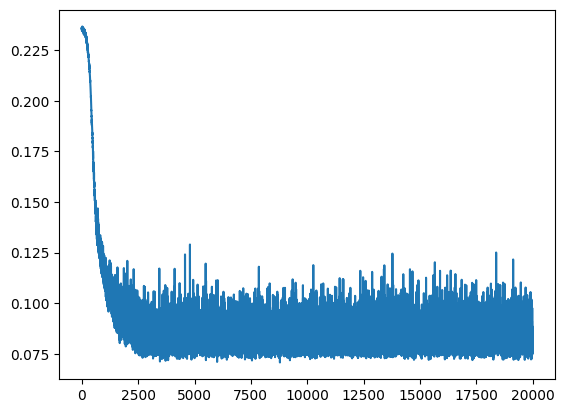

In [5]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

In [6]:
model = init_model(adata, args, device)
model.load_state_dict(torch.load(args.model_name))
model = model.to(device)
model.eval()
with torch.no_grad():
    x = model.encoder(tensor_x)
    s = model.encoder(tensor_s)
    u = model.encoder(tensor_u)
    
    v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                use_offset=args.use_offset_pred).cpu().numpy()
    x = x.cpu().numpy()
    s = s.cpu().numpy()
    u = u.cpu().numpy()

In [9]:
adata_new = new_adata(adata, 
                  x, s, u, v, 
                  n_nb_newadata=args.n_nb_newadata, # default 30 
                  X_emb_key='X_umap')

In [11]:
print(adata_new)

AnnData object with n_obs × n_vars = 9144 × 100
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'MitoCoverage', 'ClonalGroup', 'ClonalGroup.Prob', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'CellType', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    uns: 'neighbors', 'CellType_colors', 'STD.CellType_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'new_velocity', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


In [ ]:
adata_new.write_h5ad("adata/veloAE.h5ad")